In [1]:
import numpy as np
%load_ext autoreload
%autoreload 0

Notebook by **Maxime Dion** <maxime.dion@usherbrooke.ca><br>
For the QSciTech-QuantumBC virtual workshop on gate-based quantum computing

## Tutorial for the VQE Activity

For this activity, make sure you can easily import your versions of `hamiltonian.py`, `pauli_string.py` and `mapping.py` that you have completed in the mapping tutorial. You will also need your verions of `estimator.py` and `solver.py`. Placing this notebook in the same `path` as these files is the easiest way to acheive this. At the end of this notebook, you should be in good position to complete these 2 additionnal files.

The solution we suggest here is NOT mandatory. If you find ways to make it better and more efficient, go on and impress us! On the other hand, by completing all sections of this notebook you'll be able to :
- Prepare a Quantum State based on a varitional form (circuit);
- Measure qubits in the X, Y and Z basis;
- Estimate expectation value of Pauli String on a quantum state;
- Evaluate the expectation value of an Hamiltonian in the form of a Linear Combinaison of Pauli Strings;
- Run a minimization algorithm on the energy expectation function to find the ground state of a Hamiltonian;
- Dance to express your overwhelming sense of accomplishment

**Important**

When you modify and save a `*.py` file you need to re-import it so that your modifications can be taken into account when you re-execute a call. By adding the magic command `%autoreload` at the beginning of a cell, you make sure that the modifications you did to the `*.py` files are taken into account when you re-run a cell and that you can see the effect.

If you encounter unusual results, restart the kernel and try again.

**Note on numbering**

When you ask a question you can refer to the section name or the section number.

To enable the section numbering, please make sure you install [nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html). It is available in the conda distribution. After installation it you need to enable the option 'Table of contents (2)'.

# Variationnal Quantum States

Every quantum circuit starts with all qubits in the state $|0\rangle$. In order to prepare a quantum state $|\psi\rangle$ we need to prepare a `QuantumCircuit` that will modify the states of the qubits in order to get this specific state. The action of a circuit can always be represented as a unitiary operator.

\begin{align}
    |\psi\rangle &= \hat{U} |0 \ldots 0\rangle
\end{align}

For a parametric state the `QuantumCircuit` and therefore the unitary $U$ will depend on some parameters that we wirte as $\boldsymbol{\theta}$.

\begin{align}
    |\psi(\boldsymbol{\theta})\rangle &= \hat{U}(\boldsymbol{\theta}) |0 \ldots 0\rangle
\end{align}

We will see 2 ways to define Parametrized Quantum Circuits that represent Variationnal Quantum States. For the first method we only need the `QuantumCircuit` class from `qiskit.circuit`.

In [2]:
from qiskit.circuit import QuantumCircuit, Instruction

## Generating function
The easiest way to generate a parametrized `QuantumCircuit` is to implement a function that takes parameters as arguments and returns a `QuantumCircuit`. Here is such a function that generates a 2 qubits QuantumCircuit.

In [3]:
def example_2qubits_2params_quantum_circuit(theta,phi):
    qc = QuantumCircuit(2)
    qc.ry(theta,0)
    qc.rz(phi,0)
    qc.cx(0,1)
    return qc

To visualize this circuit we first need to call the generating function with dummy argument values for it to return a circuit. We can draw the circuit. The `'mpl'` option draws the circuit in a fancy way using `matplotlib`. If you are experiencing problems, you can remove this option.

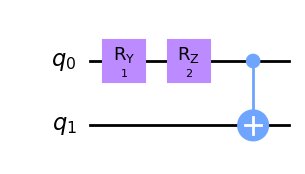

In [4]:
varform_qc = example_2qubits_2params_quantum_circuit
qc = varform_qc(1,2)
qc.draw('mpl')

## Using qiskit parameter

The other way to generate a parametrized `QuantumCircuit` is to use the `Parameter` class in `qiskit`.

In [5]:
from qiskit.circuit import Parameter

Here is the same circuit as before done with this method.

In [6]:
a = Parameter('a')
b = Parameter('b')
varform_qc = QuantumCircuit(2)
varform_qc.ry(a,0)
varform_qc.rz(b,0)
varform_qc.cx(0,1)

Done this way the parametrized circuit can be drawn right away.

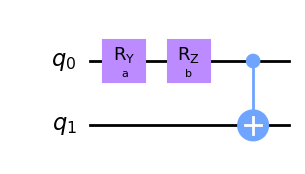

In [7]:
varform_qc.draw('mpl')

To see what are the parameters of a parametrized `QuantumCircuit` you can use

In [8]:
varform_qc.parameters

ParameterView([Parameter(a), Parameter(b)])

To assign values to the different parameters we need to use the `QuantumCircuit.assign_paremeters()` method. This methods takes a `dict` as an argument containing the `Parameter`s and their `value`s.

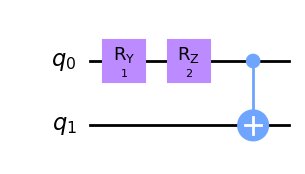

In [9]:
param_dict = {a : 1, b : 2}
qc = varform_qc.assign_parameters(param_dict)
qc.draw('mpl')

If you want to provide the parameter values as a `list` or a `np.array` you can build the `dict` directly. Just make sure that the order you use in `param_values` corresponds to the other of `varform_qc.parameters`.

In [10]:
param_values = [1, 2]
param_dict = dict(zip(varform_qc.parameters,param_values))
print(param_dict)

{Parameter(a): 1, Parameter(b): 2}


## Varforms circuits for H2
Using the method of your choice, prepare 2 different 4-qubit `QuantumCircuit`s. 
- The first should take 1 parameter to cover the real coefficients state sub space spanned by $|0101\rangle$ and $|1010\rangle$.
- The second should take 3 parameters to cover the real coefficients state sub space spanned by $|0101\rangle$, $|0110\rangle$, $|1001\rangle$ and $|1010\rangle$.

Revisit the presentation to find such circuits.

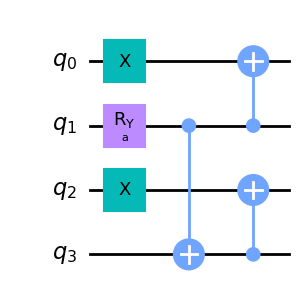

In [11]:
varform_4qubits_1param = QuantumCircuit(4)
a = Parameter('a')

varform_4qubits_1param.ry(a, [1])
varform_4qubits_1param.cx(1, 3)
varform_4qubits_1param.x([0, 2])
varform_4qubits_1param.cx([1, 3], [0, 2])

varform_4qubits_1param.draw('mpl')

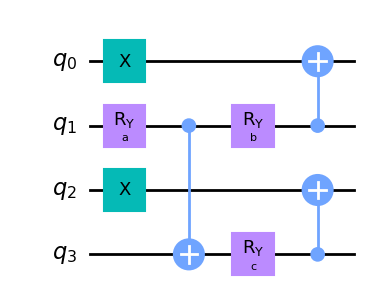

In [12]:
varform_4qubits_3params = QuantumCircuit(4)
a = Parameter('a')
b = Parameter('b')
c = Parameter('c')

varform_4qubits_3params.x([0, 2])
varform_4qubits_3params.ry(a, 1)
varform_4qubits_3params.cx(1, 3)
varform_4qubits_3params.ry(b, 1)
varform_4qubits_3params.ry(c, 3)
varform_4qubits_3params.cx(1, 0)
varform_4qubits_3params.cx(3, 2)


varform_4qubits_3params.draw('mpl')

# Estimation
The `Estimator` is an object that will help us to estimate the expectation value of an observable such as the Hamiltonian (in the form of a `LinearCombinaisonPauliString`) on a specific variational form and backend. To initialize an `Estimator` you should provide :

**Mandatory**
- A **variationnal form** that can create a `QuantumCircuit` given a set of `params`;
- A **backend** `qiskit.Backend` (a simulator or an actual device handle) on which to run the `QuantumCircuit`.

**Optional**
- `execute_opt` is a `dict` containing the optional arguments to pass to the `qiskit.execute` method (ex : `{'shots' : 1024}`);
- `record` can be a function used to record results of the estimation.

Once you'll have completed the code, the creation/usage of an `Estimator` such as `BasicEstimator` will go like this :

<code>
estimator = BasicEstimator(varform_qc, backend)<br>estimator.set_observable(observable)<br>expected_value = estimator.eval(params)
</code>

First you'll initialize the estimator.

Next, you'll provide the observables (`LinearCombinaisonPauliString`) you want to estimate the expectation value using the `set_observable()` method. 

Finally, you'll call the `eval()` method that will return the estimation of the observable's expected value. Mathematicaly, the use of this method corresponds to 

\begin{align}
E(\boldsymbol{\theta}).
\end{align}

We will now go through the different pieces neccessary to complete the `Estimator` class.

## State circuit

The first method we need to implement is `prepare_state_circuit()`. This method should take a `list` or a `ndarray` of parameters and replace them into the `varform` quantum circuit and return the `QuantumCircuit` that prepares the quantum state.

You can test you code here with the abstract class.

In [13]:
from qiskit import Aer, execute
qasm_simulator = Aer.get_backend('qasm_simulator')
from estimator import Estimator

[0.61730922]


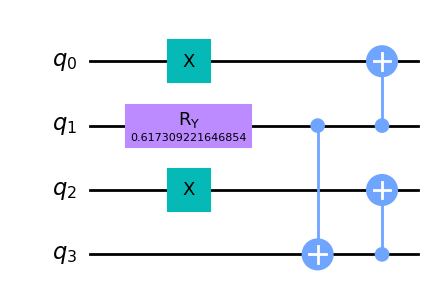

In [14]:
%autoreload
varform = varform_4qubits_1param
backend = qasm_simulator
estimator = Estimator(varform,backend)
params = np.random.random(1)
print(params)
state_circuit = estimator.prepare_state_circuit(params)

state_circuit.draw('mpl')

[0.72390171 0.16827772 0.05704856 0.55530904]


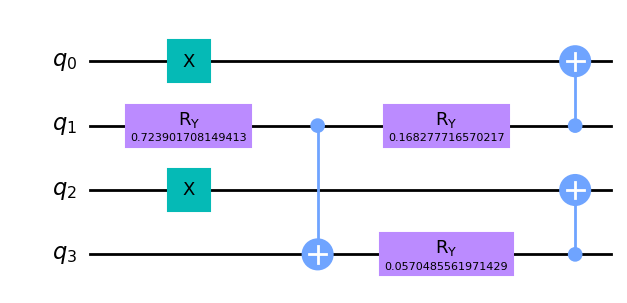

In [15]:
%autoreload
varform = varform_4qubits_3params
backend = qasm_simulator
estimator = Estimator(varform,backend)
params = np.random.random(4)
print(params)
state_circuit = estimator.prepare_state_circuit(params)

state_circuit.draw('mpl')

## Pauli Based Measurements
We want to estimate the expectation value of an observable for the quantum state we are preparing.

We have seen that even if a quantum computer can only measure qubits in the Z-basis, the X and Y-basis are accessible if we *rotate* the quantum state before measuring. 

Implement the `@staticmethod` : `diagonalizing_pauli_string_circuit()` in the `Estimator` class in file `Estimator.py` that returns a `QuantumCircuit` that performs a transformation which diagonalize the provided `PauliString`.

First we import the abstract class `Estimator` and the `PauliString` class.

In [16]:
from pauli_string import PauliString

Test your code with the next cell.

ZIZZ


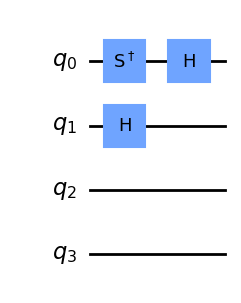

In [17]:
%autoreload
pauli_string = PauliString.from_str('ZIXY')
diagonalizing_circuit, diagonal_pauli_string = Estimator.diagonalizing_pauli_string_circuit(pauli_string)
print(diagonal_pauli_string) #should be 'ZIZZ'
diagonalizing_circuit.draw('mpl')

## Circuit and diagonal observables preperation (`BasicEstimator`)

The `diagonal_observables_and_circuits()` method is specific to the sub-types of `Estimator`. The two different types of `Estimator`s considered in this workshop are :
- The `BasicEstimator` will run a single `QuantumCircuit` for each `PauliString` present in the provided observable (`LinearCombinaisonPauliString`).
- The `BitwiseCommutingCliqueEstimator` will exploit Bitwise Commuting Clique to combine the estimation of Commuting `PauliString`s and reduce the number of different `QuantumCircuit` ran to estimate the expectation value of the observable. 

Implement the `diagonal_observables_and_circuits()` method in the `BasicEstimator` class in file `Estimator.py`. This method needs to convert each `PauliString` in the observable into a diagonal `PauliString` (of only `I` and `Z`) and a quantum circuit. The diagonal `PauliString` should then be combined with its associated coefficient into a  `LinearCombinaisonPauliString` of only one `PauliString` to form a diagonal observable. The quantum circuit should represent the transformation which convert the original `PauliString` into the respective diagonal `PauliString`. The method should return all the diagonal observables and respective quantum circuits into two `list`.

**Note** The reason the diagonal `PauliString` are returned as `LinearCombinaisonPauliString` of only one `PauliString` and not a single `LinearCombinaisonPauliString` of many `PauliString` is to facilitate the implementation of the similar methods for the `BitwiseCommutingCliqueEstimator`. You can try to implemente this second `Estimator` if you wish.

You can test your method on `2*ZIXY + 1*IXYZ`.

In [18]:
from estimator import BasicEstimator

In [19]:
%autoreload

observable = 2*PauliString.from_str('ZXZX') + 1*PauliString.from_str('IIZZ')
diagonal_observables, diagonalizing_circuits = BasicEstimator.diagonal_observables_and_circuits(observable)

for diagonal_observable in diagonal_observables:
    print(diagonal_observable)    

1 pauli strings for 4 qubits (Real, Imaginary)
ZZZZ (+2.00000,+0.00000)
1 pauli strings for 4 qubits (Real, Imaginary)
IIZZ (+1.00000,+0.00000)


You should get :

<code>
1 pauli strings for 4 qubits (Real, Imaginary)<br>
ZZZZ (+2.00000,+0.00000)<br>

1 pauli strings for 4 qubits (Real, Imaginary)<br>
IIZZ (+1.00000,+0.00000)<br>
</code>

## Set the observable

You should now be able to instantiate the `BasicEstimator` and to set an observable using `set_observable()`. This method is already implemented. It calls the `diagonal_observables_and_circuits()` method you just made and stores the `diagonal_observables` and the `diagonalizing_circuits` into the instance of the `Estimator`.

## Assemble circuits

Now that we have the state circuit and diagonalizing circuits we can assemble all the quantum circuits that will be executed in the estimation of the expectation value of the observable. The method `assemble_circuits()` assembles the state circuit with each one of the diagonalizing circuits to create as many circuits. This method should also apply the final measurements.

Once you have implemented this method you can test it here:

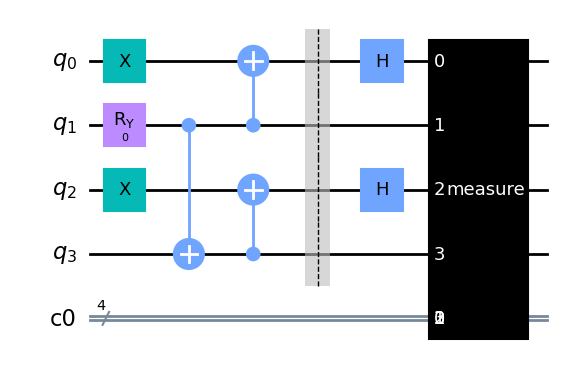

In [20]:
%autoreload

varform = varform_4qubits_1param
backend = qasm_simulator
estimator = BasicEstimator(varform, backend)
observable = 2*PauliString.from_str('ZXZX') + 1*PauliString.from_str('IIZZ')
estimator.set_observable(observable)
# print(len(estimator.diagonal_observables))
# print(len(estimator.diagonalizing_circuits))
# print(estimator.diagonalizing_circuits[0])
params = [0, ]
state_circuit = estimator.prepare_state_circuit(params)
circuits = estimator.assemble_circuits(state_circuit)
circuits[0].draw('mpl')

You should then be able to execute these circuits...

In [21]:
execute_opts = {'shots' : 1024, 'seed_simulator' : 1}
job = execute(circuits, backend=qasm_simulator, **execute_opts)
result = job.result()

... and obtain the results as counts.

In [22]:
i = 0
counts = result.get_counts(circuits[i])
print(counts)

{'0100': 245, '0000': 234, '0101': 272, '0001': 273}


/home/hassan/miniconda3/envs/winterschool/lib/python3.9/site-packages/qiskit/result/result.py:384: UserWarning: Result object contained multiple results matching name "circuit-104", only first match will be returned. Use an integer index to retrieve results for all entries.
  warnings.warn(


In [23]:
job_1 = execute(circuits[0], backend=qasm_simulator, **execute_opts)
result_1 = job_1.result()
counts_1 = result.get_counts(circuits[0])

You should get :

<code>
{'0100': 245, '0000': 234, '0101': 272, '0001': 273}
</code>

## Diagonal pauli string eigenvalue

With these counts in hands, we can tackle the last steps of the estimation of the expectation value of an observable. First we need to compute the eigenvalue of a diagonal pauli string for a given basis state. This eigenvalue can only be `+1` or `-1`. This computation should be done in the `diagonal_pauli_string_eigenvalue()` method that you can implement now.

You can test your implementation with the following code which should run `-1`.

In [24]:
%autoreload

diagonal_pauli_string = PauliString.from_str('ZIZZ')
state = '0110'
eigenvalue = Estimator.diagonal_pauli_string_eigenvalue(diagonal_pauli_string, state)
eigenvalue

-1

## Diagonal pauli string expectation value

Let's now estimate the expectation value of a single diagonal `PauliString`. This needs to be done in the method `estimate_diagonal_pauli_string_expectation_value()`. Implement this method using the one you just implemented and the following equation
\begin{align}
    \langle \hat{\mathcal{P}} \rangle = \frac{1}{N_\text{tot}}\sum_{q} N_q \Lambda_q^{(\hat{\mathcal{P}})}
\end{align}
where $\Lambda_q^{(\hat{\mathcal{P}})}$ is the eigenvalue of the `PauliString` for a state $q$ and $N_q$ is the counts, i.e. the number of times this state was measured. Testing your implementation, you should get an expectation value of `0`.

In [25]:
%autoreload

diagonal_pauli_string = PauliString.from_str('ZIZZ')
counts = {'0110' : 50, '1001' : 50}
counts = {'0110' : 50, '1001' : 61}
pauli_string_expectation_value = Estimator.estimate_diagonal_pauli_string_expectation_value(diagonal_pauli_string, counts)
pauli_string_expectation_value

0.0990990990990991

## Diagonal observable expectation value

This last step may seem a bit redundant, but it makes more sense if you try to implement the `BitwiseCommutingCliqueEstimator`. Anyhow, you need to implement the method `estimate_diagonal_observable_expectation_value()` so that it computes the expectation value of a diagonal observable by computing the linear combinaison of the diagonal pauli string expectation value, weighted by their respective coefficients.
\begin{align}
    \langle \hat{\mathcal{D}} \rangle  = \sum_i h_i \langle \hat{\mathcal{P}}_i \rangle 
\end{align}

In [26]:
%autoreload

diagonal_observable = 2*PauliString.from_str('ZZZZ') + 1*PauliString.from_str('IIZZ')
counts = {'0110' : 50, '1001' : 50}
# counts = {'0110' : 50, '1011' : 56}
observable_expectation_value = Estimator.estimate_diagonal_observable_expectation_value(diagonal_observable, counts)
observable_expectation_value

(1+0j)

Again, you should get an expectation value of `0`.

## The `eval(params)` method

You have now all the pieces to complete the `eval(params)` method. This method should use many methods you've just implemented. Mathematicaly, it should return the value of the expression

\begin{align}
    E(\boldsymbol{\theta}) = \sum_i h_i \langle\psi(\boldsymbol{\theta}) | \hat{\mathcal{P}}_i | \psi(\boldsymbol{\theta}) \rangle.
\end{align}

In [27]:
%autoreload

varform = varform_4qubits_1param
backend = qasm_simulator
execute_opts = {'shots' : 1024, 'seed_simulator' : 1}
evaluator = BasicEstimator(varform,backend,execute_opts = execute_opts)

observable = 2*PauliString.from_str('ZXZX') + 1*PauliString.from_str('IIZZ')
# observable = 2*PauliString.from_str('ZXZX') + 1*PauliString.from_str('IYZZ')
evaluator.set_observable(observable)
params = [0,]
expected_value = evaluator.eval(params)
print(expected_value)

00(-1.0234375+0j)


In [28]:
evaluator.record

(-1.0234375+0j)

Yes that's right, your code now returns an estimate of the expression

\begin{align}
    E(\theta) = \langle \psi(\theta) | \hat{\mathcal{H}} | \psi(\theta) \rangle.
\end{align} 

for

\begin{align}
    \hat{\mathcal{H}} = 2\times \hat{Z}\hat{X}\hat{Z}\hat{X} + 1\times \hat{I}\hat{I}\hat{Z}\hat{Z}
\end{align} 

and the varform `varform_4qubits_1param` with $\theta = 0$. The `evaluator.eval()` is now a method you can call like a function and it will return the energy $E(\theta)$.

Now comes the time to test this on the $\text{H}_2$ molecule Hamiltonian!

## The Hamiltonian evaluation test

We will now import the classes from the previous activity.

In [29]:
from hamiltonian import MolecularFermionicHamiltonian
from mapping import JordanWigner

For ease of use we will import the integral values instead of using `pyscf`. We also import the Coulomb repulsion energy for later use. By now we are experts in building the Hamiltonian.

In [30]:
with open('Integrals_sto-3g_H2_d_0.7350_no_spin.npz','rb') as f:
    out = np.load(f)
    h1_load_no_spin = out['h1']
    h2_load_no_spin = out['h2']
    energy_nuc =  out['energy_nuc']
    
molecular_hamiltonian = MolecularFermionicHamiltonian.from_integrals(h1_load_no_spin, h2_load_no_spin).include_spin()

In [31]:
print(molecular_hamiltonian)

Fermionic Hamiltonian
Number of orbitals : 4
Including spin : True


We use the Jordan-Wigner mapping to the get the Hamiltonian for the H2 molecule with `d=0.735`. 

In [32]:
%autoreload
mapping = JordanWigner()
qubit_hamiltonian = mapping.fermionic_hamiltonian_to_qubit_hamiltonian(molecular_hamiltonian).sort()
qubit_hamiltonian = mapping.fermionic_hamiltonian_to_qubit_hamiltonian(molecular_hamiltonian).apply_threshold().combine().apply_threshold().sort()
print(qubit_hamiltonian)

15 pauli strings for 4 qubits (Real, Imaginary)
IIII (-0.81055,+0.00000)
IIIZ (+0.17218,+0.00000)
IIZI (-0.22575,+0.00000)
IIZZ (+0.12091,+0.00000)
IZII (+0.17218,+0.00000)
IZIZ (+0.16893,+0.00000)
IZZI (+0.16615,+0.00000)
ZIII (-0.22575,+0.00000)
ZIIZ (+0.16615,+0.00000)
ZIZI (+0.17464,+0.00000)
ZZII (+0.12091,+0.00000)
XXXX (+0.04523,+0.00000)
XXYY (+0.04523,+0.00000)
YYXX (+0.04523,+0.00000)
YYYY (+0.04523,+0.00000)


We build an evaluator, feed it with the Hamiltonian (`LinearCombinaisonPauliString`) of H2 and then we evaluate the energy. Use `params` in order that your `varform` prepares the state $|0101\rangle$.

In [33]:
%autoreload
varform = varform_4qubits_1param
backend = qasm_simulator
execute_opts = {'shots' : 2048}
estimator = BasicEstimator(varform, backend, execute_opts=execute_opts)
estimator.set_observable(qubit_hamiltonian)
params = [-0.3,]
expected_value = estimator.eval(params)
print(expected_value)

000000000000000(-1.8526921532602243+0j)


If your `varform` prepares the state $|0101\rangle$, you should get something around `-1.83`. This energy is already close to the ground state energy because the ground state is close to $|0101\rangle$, but still it's not the ground state. We need to find the `params` that will minimise the energy.

\begin{align}
    E_0 = \min_{\boldsymbol{\theta}} E(\boldsymbol{\theta})
\end{align}

# Solver

In a final step we need to implement a solver that will try to find the minimal energy. We will implement 2 solvers (the second is optionnal):
  1. Use the VQE algo in conjunction with a minimizer to try to minimize `estimator.eval()`.
  2. (optional) Use the `to_matrix()` method you implemented in the previous activity to find the exact value/solution.

## VQE Solver

Like any minimzation process this solver will need a couple of ingredients :
- A function to minimize, we will provide this with the evaluator
- A minimizer, an algorithm that generaly takes in a function and a set of starting parameters and returns the best guess for the optimal parameters that correspond to the minimal value of the function to minimize.
- A set of starting parameters.

### Minimizer

A minimizer that works OK for the VQE algorithm is the  Sequential Least SQuares Programming (SLSQP) algorithm. It's available in the `minimize` sub-module of [scipy](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html).

In [34]:
from scipy.optimize import minimize

We will make a Lambda function with the minimizer so we can set all sorts of parameters before feeding it to the solver.

In [35]:
minimizer = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP', 
    options = {'maxiter' : 5, 'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 2})

The `minimizer` now takes only 2 arguments : the function and the starting parameter's values. We also specify some options :
- A small value for the maximum number of iterations. You will find that running the VQE algorithm is expansive because of the `estimator.eval()` method. Either it's long to simulate on `qasm_simulator` or because it's running on an actual quantum computer.
- A `eps` of `0.1`. This is the size of the step the algorithm is going to change the values of the parameters to try to estimate the slope of the function. By the way, a lot of minimizing algorithms use the slope of the function to know in which direction is the minimum. Since our parameters are all angles in radians a value of 0.1 seems reasonnable. Play with this value if you like.
- A `ftol` value of `1e-4`. This is the goal for the precision of the value of the minimum value. The chemical accuracy is around 1 milli-Hartree.
- We set `iprint` to `2` so to see what is going on. For your final implementation you can set this to `0`.

Before implementing the `VQESolver` let's try this minimizer! The function is `estimator.eval` and we start with a parameter of `0`.

In [36]:
%autoreload
minimization_result = minimizer(estimator.eval,[0,])

000000000000000000000000000000  NIT    FC           OBJFUN            GNORM
0000000000

/home/hassan/miniconda3/envs/winterschool/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/home/hassan/miniconda3/envs/winterschool/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


00000    1     3    -1.856165E+00     2.345485E-01
0000000000000

/home/hassan/miniconda3/envs/winterschool/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:442: ComplexWarning: Casting complex values to real discards the imaginary part
  print("%5i %5i % 16.6E % 16.6E" % (majiter, sf.nfev,


00000000000000000    2     5    -1.857724E+00     3.839774E-02
000000000000000000000000000000    3     7    -1.817970E+00     3.639202E-02
000000000000000000000000000000000000000000000000000000000000    4    11    -1.070130E+00     4.948216E-02
000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000Optimization terminated successfully    (Exit mode 0)
            Current function value: (-1.8501133204909237+0j)
            Iterations: 4
            Function evaluations: 21
            Gradient evaluations: 4


In the end you should get a minimal energy around `1.86` Hartree. Which is a bit smaller than what we had before minimizing. You can explore the `minimization_result` to retreive this value but also the set of optimal parameters.

In [37]:
opt_params = minimization_result.x
opt_value = minimization_result.fun
print(opt_params)
print(opt_value)

[-0.28576578]
(-1.8501133204909237+0j)


### VQE Solver

Now you should be in good position to implement the `lowest_eig_value(lcps)` of the `VQESolver` class inside the `Solver.py` file. Test your method here.

In [38]:
from solver import VQESolver

In [39]:
%autoreload
vqe_solver = VQESolver(estimator, minimizer, [0,], name='vqe_solver')
opt_value = vqe_solver.lowest_eig_value(qubit_hamiltonian)

000000000000000000000000000000  NIT    FC           OBJFUN            GNORM
000000000000000    1     3    -1.854511E+00     2.096358E-01
000000000000000000000000000000    2     5    -1.856510E+00     3.946232E-02
000000000000000    3     6    -1.856510E+00     2.632504E-03
Optimization terminated successfully    (Exit mode 0)
            Current function value: (-1.8565099185164862+0j)
            Iterations: 3
            Function evaluations: 6
            Gradient evaluations: 3


In [40]:
print('last opt param', vqe_solver.last_opt_params)
print('last opt value', vqe_solver.last_opt_value)

last opt param [-0.25824924]
last opt value (-1.8565099185164862+0j)


There is only one thing missing to have the complete molecular energy : the Coulomb repulsion energy from the nucleus. This value was loaded when we imported the integrals. Let's add it to the electronic energy.

In [41]:
print('Ground state position estimate (vqe) : ', vqe_solver.last_opt_params)
print('Ground state energy estimate (electronic, vqe) : ', opt_value)
print('Ground state energy estimate (molecular, vqe) : ', opt_value + energy_nuc)

Ground state position estimate (vqe) :  [-0.25824924]
Ground state energy estimate (electronic, vqe) :  (-1.8565099185164862+0j)
Ground state energy estimate (molecular, vqe) :  (-1.1365409240675066+0j)


### The Eigenstate

What is the eigenstate? We can partially find out by using the `varform` with the parameters we have found and measure everything in the Z basis.

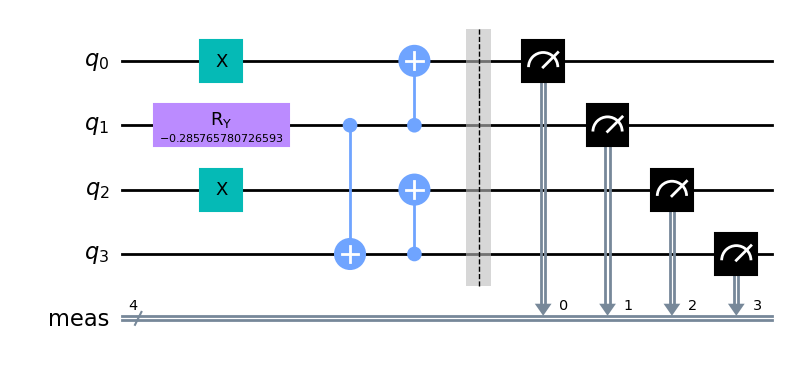

In [42]:
eigenstate_qc = varform.copy()
eigenstate_qc.measure_all()

param_dict = dict(zip(eigenstate_qc.parameters, opt_params))
eigenstate_qc = eigenstate_qc.assign_parameters(param_dict)

eigenstate_qc.draw('mpl')

We now execute this circuit.

In [43]:
execute_opts = {'shots' : 1024}
job = execute(eigenstate_qc, backend=qasm_simulator, **execute_opts)
result = job.result()
counts = result.get_counts(eigenstate_qc)

We will use the `plot_histogram` method from `qiskit.visualization` that takes the counts `dict` as an input. 

In [44]:
from qiskit.visualization import plot_histogram

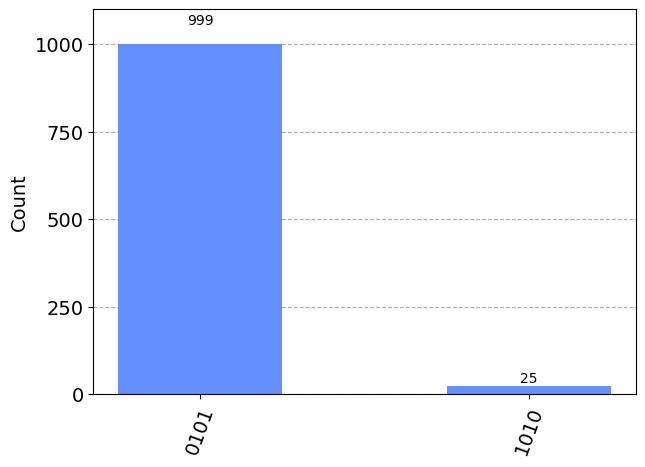

In [45]:
plot_histogram(counts)

We see that the found solution is mostly the state $|0101\rangle$ which is the Hartree-Fock solution when the 2-body Hamiltonian is not present. Adding this 2-body physics shifts the energy down a bit by introducing a small contribution of $|1010\rangle$. The actual statevector has a `-` sign between these two states.

\begin{align}
\alpha_{0101}|0101\rangle - \alpha_{1010}|0101\rangle
\end{align}

But this is not something we can know from this. Fortunatly, H2 is a small system which can be solved exactly and we can find out this phase.

## Exact Solver (optional)

If you want to compare the value you get with the VQE algorithm it would be nice to have the exact value. If you were able to implement the `to_matrix()` method for `PauliString` and `LinearCombinaisonPauliString` then you can find the exact value of the ground state. All you need is to diagonalise the matrix reprensenting the whole Hamiltonian and find the lowest eigenvalue! Obviously this will not be possible to do for very large systems.

In [46]:
hamiltonian_matrix = qubit_hamiltonian.to_matrix()
eig_values, eig_vectors = np.linalg.eigh(hamiltonian_matrix)
eig_order = np.argsort(eig_values)
eig_values = eig_values[eig_order]
eig_vectors = eig_vectors[:,eig_order]
ground_state_value, ground_state_vector = eig_values[0], eig_vectors[:,0]
print('Ground state vector (exact) : ', ground_state_vector)
print('Ground state energy (electronic, exact) : ', ground_state_value)
print('Ground state energy (molecular, exact) : ', ground_state_value + energy_nuc)

Ground state vector (exact) :  [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.11153594+0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j -0.9937604 +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
Ground state energy (electronic, exact) :  -1.857275030202378
Ground state energy (molecular, exact) :  -1.1373060357533982


Now you can complete the `ExactSolver` in the `Solver.py` file.

In [47]:
from solver import ExactSolver

In [48]:
%autoreload
exact_solver = ExactSolver()
ground_state_value, ground_state_vector = exact_solver.lowest_eig_value(qubit_hamiltonian)
print('Ground state vector (exact) : \n', ground_state_vector.real.round(2))
print('Ground state energy (electronic, exact) :', ground_state_value.round(2))
print('Ground state energy (molecular, exact) :', ground_state_value + energy_nuc)

Ground state vector (exact) : 
 [ 0.    0.    0.    0.    0.    0.11  0.    0.    0.    0.   -0.99  0.
  0.    0.    0.    0.  ]
Ground state energy (electronic, exact) : -1.86
Ground state energy (molecular, exact) : -1.1373060357533982


What are the two basis states involved in the ground state? Let's plot the state vector using `matplotlib`.

In [49]:
import matplotlib.pyplot as plt

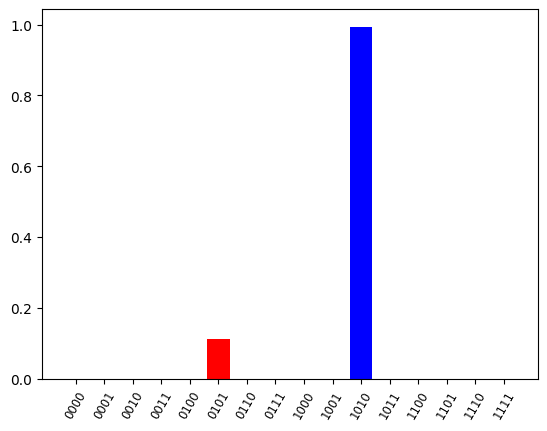

In [50]:
fig,ax = plt.subplots(1,1)
i_max = np.argmax(np.abs(ground_state_vector))
state = ground_state_vector * np.sign(ground_state_vector[i_max])
ax.bar(range(len(state)), np.abs(state), color=(np.real(state) > 0).choose(['r','b']))
plt.xticks(range(len(state)),[f"{i:04b}" for i in range(len(state))], size='small',rotation=60);

# What's next?

Now that you can find the ground state for a specific H2 molecule configuration (`d = 0.735`), you should be able to do that for many configurations, say `d = 0.2` to `2.5`. Doing that will enable you to plot the so-called dissociation curve : energy vs distance. Do not forget to include the Coulomb repulsion energy of the nucleus!

You could also run your algorithm on a noisy backend, either a noisy simulator or a real quantum computer. You've already seen on day 1 how to set/get a noisy backend. You'll see that noise messes things up pretty bad.

Running on real machine will introduce the problem of the qubit layout. You might want to change the `initial_layout` in the `execute_opts` so that your `varform` is not applying CNOT gates between qubits that are not connected. You know this needs to insert SWAP gates and this introduces more noise. Also covered in day 1.

To limit the effect of readout noise, you could add a `measure_filter` to your `evaluator`, so that each time you execute the `eval_circuits` you apply the filter to the results. Also covered in day 1.

Implement the simulatneous evaluation for bitwise commuting cliques or even for general commuting cliques.

In [52]:
minimizer_d = lambda fct, start_param_values : minimize(
    fct,
    start_param_values,
    method = 'SLSQP',
    options = {'maxiter' : 5, 'eps' : 1e-1, 'ftol' : 1e-4, 'disp' : True, 'iprint' : 0})

/tmp/ipykernel_501109/2628002570.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()
/tmp/ipykernel_501109/2628002570.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  E_quan_noisy[i] = quan_noisy_vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()
/tmp/ipykernel_501109/2628002570.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  E_full_noisy[i] = full_noisy_vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()
/tmp/ipykernel_501109/2628002570.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  E_miti_noisy[i] = miti_noisy_vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

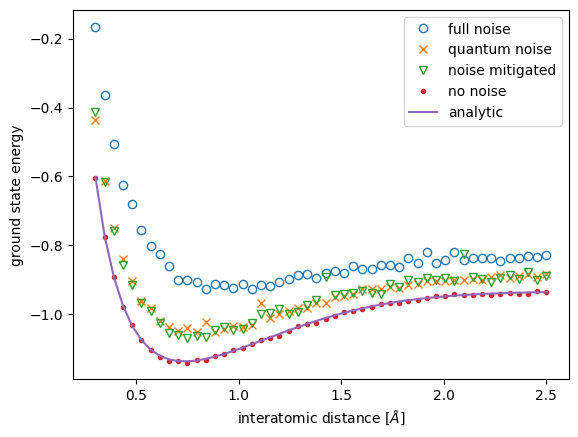

In [131]:
%autoreload
from matplotlib import pyplot as plt
from pyscf import gto
import qiskit_aer.noise as noise
from qiskit_ibm_runtime import Options, QiskitRuntimeService, Sampler

mapping = JordanWigner()

varform = varform_4qubits_1param
backend = qasm_simulator
execute_opts = {'shots' : 2048}
Nd = 50  # length of distance array

'''only quantum error'''
# Error probabilities
prob_1 = 0.01  # 1-qubit gate
prob_2 = 0.05   # 2-qubit gate
# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
# Add errors to noise model
quan_noise_model = noise.NoiseModel()
quan_noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
quan_noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
quan_noisy_exe_opts = {'shots' : 2048, 'noise_model' : quan_noise_model}

'''adding readout error'''
# Error probabilities
p_err = 0.15  # probability of reading something else
# building error matrix assuming uniform distribution of errors
error_matrix = p_err * np.ones((16, 16)) / 15 + (1 - 16*p_err/15) * np.eye(16)
readout_err = noise.ReadoutError(error_matrix)
# Add errors to noise model
full_noise_model = noise.NoiseModel()
full_noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
full_noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
full_noise_model.add_readout_error(readout_err, range(4))
full_noisy_exe_opts = {'shots' : 2048, 'noise_model' : full_noise_model}

# generating the estimators
estimator = BasicEstimator(varform, backend, execute_opts=execute_opts)
quan_noisy_estimator = BasicEstimator(varform, backend, execute_opts=quan_noisy_exe_opts)
full_noisy_estimator = BasicEstimator(varform, backend, execute_opts=full_noisy_exe_opts)
miti_noisy_estimator = BasicEstimator(varform, backend, execute_opts=full_noisy_exe_opts, mitigate=True)

# computation
distance = np.linspace(0.3, 2.5, Nd) #units in AA
E_exact = np.zeros(len(distance))
E = np.zeros(len(distance))
E_quan_noisy = np.zeros(len(distance))
E_full_noisy = np.zeros(len(distance))
E_miti_noisy = np.zeros(len(distance))

for i in range(len(distance)):
    mol_d = gto.M(
            atom = [['H', (0,0,-distance[i]/2)], ['H', (0,0,distance[i]/2)]], 
            basis = 'sto-3g'
            )
    
    molecular_hamiltonian_no_spin_d = MolecularFermionicHamiltonian.from_pyscf_mol(mol_d)
    molecular_hamiltonian_d = molecular_hamiltonian_no_spin_d.include_spin()
    qubit_hamiltonian_d = mapping.fermionic_hamiltonian_to_qubit_hamiltonian(molecular_hamiltonian_d).apply_threshold().combine().apply_threshold().sort()
    
    h1_no_spin_d, h2_no_spin_d = molecular_hamiltonian_no_spin_d.get_integrals()
    Eg = h1_no_spin_d[0, 0]
    Eu = h1_no_spin_d[1, 1]
    Ug = h2_no_spin_d[0, 0, 0, 0]
    Uu = h2_no_spin_d[1, 1, 1, 1]    
    Vd = h2_no_spin_d[1, 0, 0, 1]
    Vx = h2_no_spin_d[1, 0, 1, 0]
    
    estimator.set_observable(qubit_hamiltonian_d)    
    quan_noisy_estimator.set_observable(qubit_hamiltonian_d)
    full_noisy_estimator.set_observable(qubit_hamiltonian_d)
    miti_noisy_estimator.set_observable(qubit_hamiltonian_d)
    
    vqe_solver = VQESolver(estimator, minimizer_d, [0,], name='vqe_solver')
    quan_noisy_vqe_solver = VQESolver(quan_noisy_estimator, minimizer_d, [0,], name='vqe_solver')
    full_noisy_vqe_solver = VQESolver(full_noisy_estimator, minimizer_d, [0,], name='vqe_solver')
    miti_noisy_vqe_solver = VQESolver(miti_noisy_estimator, minimizer_d, [0,], name='vqe_solver')

    A = 2*Eg + Ug
    B = 2*Eu + Uu
    E_exact[i] = 0.5 * (A + B - np.sqrt((A - B)**2 + 4*Vx**2)) + mol_d.energy_nuc()    
    E[i] = vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()    
    E_quan_noisy[i] = quan_noisy_vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()
    E_full_noisy[i] = full_noisy_vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()
    E_miti_noisy[i] = miti_noisy_vqe_solver.lowest_eig_value(qubit_hamiltonian_d) + mol_d.energy_nuc()
    print(i, end=' ')
    # print('diff =', E0[i] - E[i])


plt.plot(distance, E_full_noisy, 'o', mfc='none', label='full noise')
plt.plot(distance, E_quan_noisy, 'x', label='quantum noise')
plt.plot(distance, E_miti_noisy, 'v', mfc='none', label='noise mitigated')
plt.plot(distance, E, '.', label='no noise')
plt.plot(distance, E_exact, label='analytic')
plt.xlabel('interatomic distance [$\AA$]')
plt.ylabel('ground state energy')
plt.legend()

Notebook by **Maxime Dion** <maxime.dion@usherbrooke.ca><br>
For the QSciTech-QuantumBC virtual workshop on gate-based quantum computing